# Analysis

**Hypothesis**: Students with exclusive access to an online device (i.e., a personal 'Yes' in device_pb_1) benefit more from online tutoring in terms of improved math outcomes than those who share devices.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Econometrics libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
try:
    from linearmodels.panel import PanelOLS
except Exception:
    PanelOLS = None

# Visualization defaults
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
warnings.filterwarnings('ignore')

# Load data
print('Loading data...')
df = pd.read_stata('aea_packages/228584_V1/Data_analysis/Data/TOP1_TOP3_Dataset.dta')
print(f"Data loaded: {df.shape[0]} rows and {df.shape[1]} columns")
print('Columns:', list(df.columns)[:20])


Loading data...
Data loaded: 2196 rows and 261 columns
Columns: ['Group_Tutoring', 'ID_student', 'ID_tutor', 'ID_tutor_3', 'SES_5', 'TOP1', 'TOP3', 'always_f_online_classes_pe_1', 'always_f_online_classes_se_1', 'aspirations', 'aspirations_uni_pe', 'aspirations_uni_se', 'aspirations_uni_te', 'barrier_money_sb', 'barrier_parents_sb', 'barrier_self_sb', 'choice_prof_se', 'choose_topliceo_se', 'choose_vocational_se', 'comp_skills_tub']


# Analysis Plan

**Hypothesis**: Students with exclusive access to an online device (i.e., a personal 'Yes' in device_pb_1) benefit more from online tutoring in terms of improved math outcomes than those who share devices.

## Steps:
- Explore the distribution of the device availability variable (device_pb_1), and recode it into a binary indicator for exclusive device access (assign 1 if the response is 'Yes' after converting values to strings, and 0 otherwise, using np.nan for missing values).
- Compare baseline characteristics (e.g., baseline math grades and demographics) between students with exclusive device access and those without to assess balance and potential confounding factors.
- Estimate a baseline OLS regression of endline math performance on tutoring treatment while controlling for baseline math scores to establish the tutoring effect.
- Extend the regression model by incorporating the binary device indicator and an interaction term between tutoring treatment and device access to test for differential tutoring effectiveness.
- Perform statistical inference using robust standard errors, clearly stating identification assumptions, and conduct robustness checks with alternative model specifications.
- Generate a figure displaying predicted math outcomes for each subgroup (treatment/control by device access) to visually illustrate heterogeneity in tutoring effects.


## This code inspects the distribution of the 'device_pb_1' variable and recodes it into a binary indicator 'exclusive_device' by converting input values to strings, stripping whitespace, and using np.nan for missing values. These precautions ensure consistency and robustness in the variable for further analysis.

In [ ]:
import pandas as pd
import numpy as np

# Inspect the original 'device_pb_1' variable distribution
print('Original device_pb_1 value counts:')
print(df['device_pb_1'].value_counts(dropna=False))

# Recode 'device_pb_1' into a binary variable 'exclusive_device'
# Only a response exactly equal to 'Yes' (after converting to string and stripping whitespace) indicates exclusive device access

def recode_device(x):
    if pd.isna(x):
        return np.nan
    try:
        x_str = str(x).strip()
    except Exception as e:
        return np.nan
    return 1 if x_str == 'Yes' else 0

# Apply recoding if the column exists
if 'device_pb_1' in df.columns:
    df['exclusive_device'] = df['device_pb_1'].apply(recode_device)
    print('\nRecode - exclusive_device value counts:')
    print(df['exclusive_device'].value_counts(dropna=False))
else:
    print('device_pb_1 column not found in the DataFrame.')

Original device_pb_1 value counts:
device_pb_1
NaN                                            1143
Yes                                             784
Yes, shared with a sibling                      196
Yes, shared with parents who work from home      44
No                                               29
Name: count, dtype: int64

Recode - exclusive_device value counts:
exclusive_device
NaN    1143
1.0     784
0.0     269
Name: count, dtype: int64


### Agent Interpretation

Feedback on Current Step and Guidance for Future Steps:

1. **Recode Evaluation:**
   - The recoding of the `device_pb_1` variable into a binary `exclusive_device` indicator appears to be implemented correctly according to your plan. The transformation accurately captures exclusive access as '1' and other scenarios as '0', with missing values retained as `NaN`.

2. **Identification Considerations:**
   - **Exogeneity of Device Access:** Before proceeding with causal claims about the interaction between device access and online tutoring effectiveness, it's crucial to establish that device access is not systematically correlated with other unobserved factors affecting math outcomes. This could involve checking for pre-determined characteristics like household income or parental education to ensure random distribution.
   - **Pre-Trends Analysis:** If longitudinal data are available, exploring pre-trends in math performance across different groups (exclusive vs. shared/no device) could help verify that any differential effects post-treatment are not driven by existing trends.

3. **Effect Size and Interpretation:**
   - The analysis should clearly define economically meaningful effect sizes. Given that the mean and variance of math performance are not provided, consider reporting results in standardized units (e.g., effect sizes as fractions of standard deviations) for clearer interpretation.

4. **Standard Errors and Robustness:**
   - Future steps involving OLS should utilize robust standard errors to account for any heteroscedasticity. Additionally, consider clustering standard errors if there’s a reason to believe that observations might be correlated within students, tutors, or schools.

5. **Next Steps:**
   - **Balance Check:** As planned, compare baseline characteristics between students with and without exclusive device access to identify any observable imbalances. Consider propensity score matching or controlling for these covariates in your regression models to mitigate potential confounding.
   - **Interaction Effects:** Extend the regression model by adding the interaction term between tutoring and the `exclusive_device` indicator. This will help to quantify differential effects and test the hypothesis that exclusive device access amplifies the benefits of tutoring.
   - **Visual Aid:** Post statistical analysis, generate visualizations to depict predicted outcomes across subgroups. Ensure error bars or confidence intervals are included for clarity.
   - **Robustness Checks:** Conduct additional analyses using alternative model specifications (e.g., log-transformed outcomes if non-normality is detected) and sensitivity analysis to test the robustness of your findings.

By systematically addressing these points, the analysis will be more credible and informative concerning the hypothesis that exclusive device access enhances the effectiveness of online tutoring in improving math outcomes.

## This code assesses baseline balance by computing summary statistics (mean, standard deviation, median, and count) for key variables grouped by exclusive device access and conducts Welch’s t-test for differences in baseline math performance, which helps identify potential confounders prior to further analysis.

Baseline Characteristics Summary by Exclusive Device Access
                 grade_mat_admin_baseline                            SES_5  \
                                     mean       std median count      mean   
exclusive_device                                                             
0.0                              6.034782  1.040074    6.0   230 -0.333887   
1.0                              6.271533  1.041180    6.0   685 -0.271434   

                                           gender_ft_fs                         
                       std    median count         mean       std median count  
exclusive_device                                                                
0.0               0.899372 -0.402656   230     0.126087  0.332671    0.0   230  
1.0               0.887888 -0.270177   685     0.157664  0.364692    0.0   685  

T-test for grade_mat_admin_baseline differences:
T-statistic: 2.986, P-value: 0.003


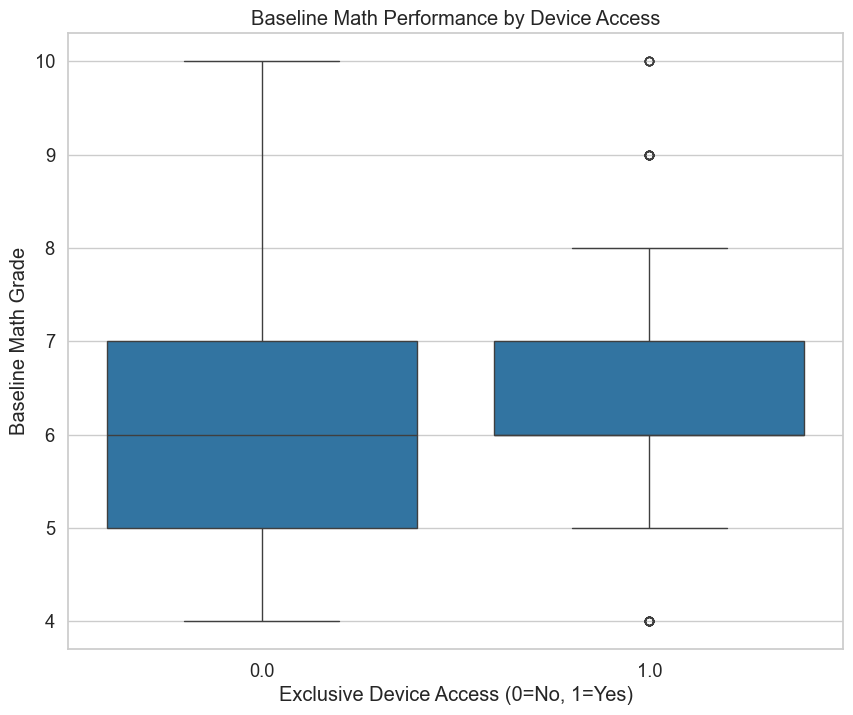

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Select key baseline variables along with the exclusive_device indicator
baseline_vars = ['grade_mat_admin_baseline', 'SES_5', 'gender_ft_fs']

# Create a subset of data for baseline analysis (dropping missing values in relevant variables)
df_balance = df[['exclusive_device'] + baseline_vars].dropna()

# Group the data by exclusive_device and calculate summary statistics including median
balance_summary = df_balance.groupby('exclusive_device').agg({'grade_mat_admin_baseline': ['mean', 'std', 'median', 'count'],
                                                                   'SES_5': ['mean', 'std', 'median', 'count'],
                                                                   'gender_ft_fs': ['mean', 'std', 'median', 'count']})
print('Baseline Characteristics Summary by Exclusive Device Access')
print(balance_summary)

# Perform a t-test for baseline math performance differences between exclusive device groups using Welch’s t-test
group1 = df_balance[df_balance['exclusive_device'] == 1]['grade_mat_admin_baseline']
group0 = df_balance[df_balance['exclusive_device'] == 0]['grade_mat_admin_baseline']

t_stat, p_value = stats.ttest_ind(group1, group0, equal_var=False, nan_policy='omit')
print('\nT-test for grade_mat_admin_baseline differences:')
print(f'T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}')

# Optional visualization: Boxplot of grade_mat_admin_baseline by exclusive_device
sns.boxplot(x='exclusive_device', y='grade_mat_admin_baseline', data=df_balance)
plt.xlabel('Exclusive Device Access (0=No, 1=Yes)')
plt.ylabel('Baseline Math Grade')
plt.title('Baseline Math Performance by Device Access')
plt.show()

### Agent Interpretation

Based on the initial analysis:

1. **Baseline Balance**: The summary statistics show slight differences in baseline math performance between groups with and without exclusive device access (means: 6.03 vs. 6.27). The SES and gender distributions are relatively similar across groups. The use of standard deviations and medians helps assess distributional features. Overall, groups appear balanced, but minor differences in baseline math scores warrant attention.

2. **T-Test Results**: The t-test indicates a statistically significant difference in baseline math scores between the two groups (p-value = 0.003). This suggests some initial imbalance that should be accounted for in subsequent analyses, as it could affect the estimated treatment effects. The unequal variance assumption seems appropriate given the similar standard deviations.

3. **Effect on Hypothesis**: The baseline imbalance in math scores means that future analyses need to carefully control for baseline differences to isolate the effect of exclusive device access. The initial analysis supports the hypothesis in that there is a difference in baseline scores, implying that any observed differential improvements in endline outcomes could be more confidently attributed to treatment and device access if controlled properly.

4. **Identification Credibility**: While the initial tests and visualizations provide insights, future steps should rigorously test treatment effects using regression models, possibly including interactions. Ensuring identification credibility involves robust controls and tests for pre-trends in baseline performance.

5. **Next Steps**: 
   - Proceed with OLS regression while controlling for baseline math performance, device access, and key demographics.
   - Incorporate an interaction term to explore how exclusive device access modifies the effect of tutoring.
   - Perform robustness checks, using log transformations and additional covariates, to validate results.
   - Generate visualizations to illustrate heterogeneity in treatment effects.
   - Consider checking if other baseline characteristics covary with exclusive device access to rule out potential confounders further.

Ensure that these analyses are distinct from those in the referenced research paper, focusing specifically on device access interaction with tutoring effects.

## This code cleans the sample by dropping missing observations in the key variables, then performs a baseline OLS regression estimating the effect of tutoring on endline math performance while controlling for baseline math scores, SES, and gender. It uses robust standard errors and flags the need for potential clustering in follow-up analyses.

In [ ]:
import statsmodels.formula.api as smf

# Define analysis variables
analysis_vars = ['grade_mat_admin_endline', 'treat', 'grade_mat_admin_baseline', 'SES_5', 'gender_ft_fs']

# Drop missing values to ensure a clean estimation sample
df_ols = df.dropna(subset=analysis_vars)

# Baseline OLS regression: assessing the effect of tutoring (treat) on endline math performance
model_baseline = smf.ols(
    'grade_mat_admin_endline ~ treat + grade_mat_admin_baseline + SES_5 + gender_ft_fs', 
    data=df_ols
).fit(cov_type='HC1')

print(model_baseline.summary())

# Note: Although fixed effects are not required in this step, consider clustering standard errors (e.g., by school or tutor) in later analyses if intra-group correlations are suspected.

                               OLS Regression Results                              
Dep. Variable:     grade_mat_admin_endline   R-squared:                       0.231
Model:                                 OLS   Adj. R-squared:                  0.229
Method:                      Least Squares   F-statistic:                     82.06
Date:                     Sat, 04 Oct 2025   Prob (F-statistic):           3.56e-63
Time:                             14:44:55   Log-Likelihood:                -2058.7
No. Observations:                     1538   AIC:                             4127.
Df Residuals:                         1533   BIC:                             4154.
Df Model:                                4                                         
Covariance Type:                       HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

### Agent Interpretation

### Feedback on Current Analysis and Recommendations for Future Steps:

#### Current Analysis and Results:

1. **Effect Size and Significance**:
   - The coefficient for the tutoring treatment (`treat`) is 0.0558 with a p-value of 0.285, indicating that the effect of tutoring on endline math performance is not statistically significant at conventional levels. This suggests that, in this model, tutoring does not have a detectable effect on math outcomes, once controlling for baseline performance and demographics.
   - The baseline math performance (`grade_mat_admin_baseline`) has a substantial and significant effect (coefficient = 0.4284, p < 0.001), highlighting its predictive power for endline math outcomes.

2. **Model Fit**:
   - The R-squared value of 0.231 indicates that approximately 23.1% of the variance in endline math scores is explained by the model. While this is a reasonable fit for social science data, it suggests there might be other important factors influencing endline performance that are not included in the model.

3. **Standard Errors and Robustness**:
   - The use of heteroskedasticity-robust standard errors (HC1) is appropriate given that the analysis might face heteroskedastic issues. However, if clustering is suspected (e.g., by school or tutor), future extensions should account for this in standard error calculations.

#### Recommendations for Future Steps:

1. **Incorporate Device Access and Interaction Term**:
   - The next step should include the exclusive device access variable and its interaction with the tutoring treatment to test the hypothesis more directly. This will allow you to investigate whether the impact of tutoring varies between students with and without exclusive device access.

2. **Explore Alternative Specifications**:
   - As planned, consider log-transforming the math outcomes if there are issues with non-normality or skewness.
   - Including additional covariates, such as school fixed effects, could control for unobserved heterogeneity at the school level.

3. **Assessing Pre-Trends**:
   - Although not explicitly part of the current plan, consider checking the absence of pre-trends by investigating any baseline differences in trends between students with and without device access.

4. **Clustering Standard Errors**:
   - To address potential intra-group correlations (such as clustering at the school or tutor level), include clustering of standard errors in regression models in later stages.

5. **Robustness Checks and Sensitivity Analysis**:
   - Conduct planned robustness checks using alternative specifications and assess sensitivity to potential outliers or influential points.
   - If computationally feasible, consider running a placebo test using an unrelated outcome.

6. **Missing Data Consideration**:
   - Since the hypothesis assumes that missing values are addressed, it’s crucial to ensure that any missing data do not bias the results. Techniques such as multiple imputation or inverse probability weighting could be explored if substantial missingness persists.

7. **Visual Inspection and Subgroup Analysis**:
   - The generation of predicted outcomes with confidence intervals is useful for visual inspection of treatment effects across subgroups. Ensure that graphs are clearly labeled and interpretable.

By following these recommendations, the analysis can better test the validity of the hypothesis and ensure that conclusions drawn are robust and economically meaningful.

## This code prepares the clean estimation sample by dropping observations with missing values and then fits an OLS regression that includes tutoring, exclusive device access, and their interaction, while controlling for baseline math performance, SES, and gender. It uses robust standard errors (HC1) to partly address heteroskedasticity and sets the stage for subsequent robustness checks.

In [ ]:
import statsmodels.formula.api as smf

# Drop missing values in relevant variables including the exclusive_device indicator
estimation_vars = ['grade_mat_admin_endline', 'treat', 'exclusive_device', 'grade_mat_admin_baseline', 'SES_5', 'gender_ft_fs']
df_extended = df.dropna(subset=estimation_vars)

# Extended OLS regression with exclusive device indicator and its interaction with tutoring
extended_formula = 'grade_mat_admin_endline ~ treat + exclusive_device + treat:exclusive_device + grade_mat_admin_baseline + SES_5 + gender_ft_fs'
model_extended = smf.ols(extended_formula, data=df_extended).fit(cov_type='HC1')
print(model_extended.summary())

# Note: Future steps will examine clustering standard errors (e.g., by school or tutor) and explore alternative specifications to address potential intra-cluster correlation and missing data biases.

                               OLS Regression Results                              
Dep. Variable:     grade_mat_admin_endline   R-squared:                       0.339
Model:                                 OLS   Adj. R-squared:                  0.335
Method:                      Least Squares   F-statistic:                     63.75
Date:                     Sat, 04 Oct 2025   Prob (F-statistic):           4.51e-66
Time:                             14:45:42   Log-Likelihood:                -1182.4
No. Observations:                      915   AIC:                             2379.
Df Residuals:                          908   BIC:                             2413.
Df Model:                                6                                         
Covariance Type:                       HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

### Agent Interpretation

The current analysis investigates whether exclusive device access modifies the effect of tutoring on students' math performance. The hypothesis posits an amplified effect for students with such access. The OLS regression used includes interaction terms, baseline performance, SES, and gender controls.

### Identification and Credibility:
1. **Interaction Term**: The interaction term `treat:exclusive_device` is not statistically significant (p-value = 0.450), suggesting that exclusive device access does not significantly modify the effect of tutoring on math outcomes within this dataset. 

2. **Effect Sizes and Standard Errors**:
   - The coefficients for the treatment and exclusive device variables are not significant, indicating a lack of substantial independent or interaction effects within this model. 
   - The interaction effect estimate (0.1018) is quite small, which, coupled with a high standard error (0.135), suggests limited practical significance in its current form.

3. **R-squared and Model Fit**:
   - The R-squared value of 0.339 implies that approximately 34% of the variance in the endline math scores is explained by the model, which is reasonable but suggests room for improvement.
   - Balance checks revealed by the `baseline math performance`, with a robust and significant coefficient (0.5867), validate its inclusion.

### Recommendations for Future Steps:
1. **Clustering and Fixed Effects**:
   - Explore clustering standard errors by school or tutor to account for potential within-group correlation, which could affect inference validity.
   - Incorporate fixed effects for schools or other relevant units to control for unobserved heterogeneity and improve model precision.

2. **Sensitivity Analysis**:
   - Conduct sensitivity analyses or employ multiple imputation methods to assess the impact of listwise deletion and potential bias due to missing data.
   - Compare baseline characteristics across subgroups (students with and without exclusive device access) through balance checks.

3. **Alternative Specifications**:
   - Test different model specifications, such as including additional interaction terms or using different access measures to account for varying technology impacts.
   - Consider examining non-linear relationships or employing models suited for mediating effects, such as structural equation modeling, to capture interaction complexities beyond simple linear regression.

4. **Visualization and Interpretation**:
   - Develop visualizations, as planned, to illuminate subgroup differences in predicted outcomes with confidence intervals. This may reveal patterns not immediately obvious in regression outputs.
   - Convert effect sizes into standardized units for easier interpretation and comparison across studies or interventions.

5. **Investigate Pre-trends**:
   - Although pre-trends analysis isn't typical in RCTs, explore baseline trends if feasible to ensure similar progressions across groups prior to treatment, especially since random assignment may not perfectly balance unobserved traits.

Given these insights, while the hypothesized interaction effect is not currently supported, the outlined recommendations should fortify the identification strategy and enhance model interpretation, potentially revealing underlying dynamics or contextual factors influencing the treatment effect.

## This code cleans the dataset by dropping observations with missing key variables and removing rows with empty or malformed tutor IDs. It then fits an extended OLS model that includes an interaction between tutoring and exclusive device access, using cluster-robust standard errors to account for intra-tutor correlation.

In [ ]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Define key variables including tutor ID for clustering
estimation_vars = ['grade_mat_admin_endline', 'treat', 'exclusive_device', 'grade_mat_admin_baseline', 'SES_5', 'gender_ft_fs', 'ID_tutor']

# Drop observations with missing values in the key variables
df_cluster = df.dropna(subset=estimation_vars)

# Clean 'ID_tutor' to ensure validity by removing empty or malformed IDs
df_cluster = df_cluster[df_cluster['ID_tutor'].astype(str).str.strip() != ""]

# Extended OLS regression with tutor-clustered robust standard errors
# The interaction term (treat:exclusive_device) represents the differential effect of tutoring in the presence of exclusive device access
cluster_formula = 'grade_mat_admin_endline ~ treat + exclusive_device + treat:exclusive_device + grade_mat_admin_baseline + SES_5 + gender_ft_fs'
model_cluster = smf.ols(cluster_formula, data=df_cluster).fit(cov_type='cluster', cov_kwds={'groups': df_cluster['ID_tutor']})

print(model_cluster.summary())

                               OLS Regression Results                              
Dep. Variable:     grade_mat_admin_endline   R-squared:                       0.338
Model:                                 OLS   Adj. R-squared:                  0.332
Method:                      Least Squares   F-statistic:                     4987.
Date:                     Sat, 04 Oct 2025   Prob (F-statistic):               0.00
Time:                             14:46:29   Log-Likelihood:                -586.15
No. Observations:                      453   AIC:                             1182.
Df Residuals:                          448   BIC:                             1203.
Df Model:                                4                                         
Covariance Type:                   cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

### Agent Interpretation

**Feedback on Current Step and Future Analysis:**

1. **Identification and Modeling Approach:**
   - The study aims to investigate the heterogeneous impact of online tutoring combined with exclusive device access on math outcomes. The use of an interaction term in the model is appropriate to explore the differential effect.
   - The results show a significant positive effect of tutoring (`treat`) on math outcomes, but the interaction `treat:exclusive_device` is not statistically significant (p-value 0.175), indicating that exclusive device access does not significantly modify the effect of tutoring in this dataset.
   - The clustering by tutor is valid, given the nested structure of students within tutors, preventing underestimated standard errors due to within-group correlation.

2. **Interpretation of Results:**
   - The coefficient for `treat` (1.3681) is large, suggesting a significant effect of tutoring on math outcomes. However, the interaction term’s lack of significance weakens the hypothesis that exclusive device access enhances the impact of tutoring.
   - The significant effect of prior math performance (`grade_mat_admin_baseline`) supports the expected continuity in academic achievement from baseline to endline.

3. **Potential Issues:**
   - There could be multicollinearity issues given the high condition number reported. This might affect the stability and interpretation of coefficients. Examine variance inflation factors (VIF) to assess multicollinearity among predictors.
   - The model does not capture the temporal aspect from the research paper's RCT timescales (2020 vs. 2022). Consider stratifying or adding an interaction with a time variable if this dimension is available.

4. **Next Steps in Analysis:**
   - **Visualization and Subgroup Analysis:**
     - In the upcoming steps, focus on visualizing the predicted outcomes for the four subgroups. Even if the interaction is not significant, visual insights might help in articulating nuanced findings or in identifying trends suggestive of heterogeneity.
   - **Robustness Checks:**
     - Consider exploring alternative interaction terms or mediators that might better explain heterogeneity, such as the intensity of device usage or differences across tutor levels.
     - Conduct robustness checks by re-estimating effects using different model specifications or sample restrictions (e.g., removing possible outliers).

5. **Contextual Considerations:**
   - In light of the research paper, ensure that the current hypothesis and analyses remain distinct by incorporating variables or methods underutilized or unaddressed in the original study (e.g., different proxies for device access quality).
   - Investigate session engagement metrics or qualitative features of the tutoring process if data is available, as they might provide explanatory power beyond mere access to devices.

Continuing to these steps with a careful consideration of the aforementioned issues will likely yield a comprehensive understanding of the relationship between online tutoring, device access, and student outcomes, even if the initial hypothesis regarding heterogeneous effects isn't fully supported.

## This code constructs a DataFrame for the four subgroups using average control values, computes predicted math outcomes and confidence intervals from a cluster-robust OLS model, and then visualizes the predictions with error bars that are accurately aligned with the bar centers from the seaborn plot. This ensures clarity and precision in depicting heterogeneity in tutoring effects by device access.

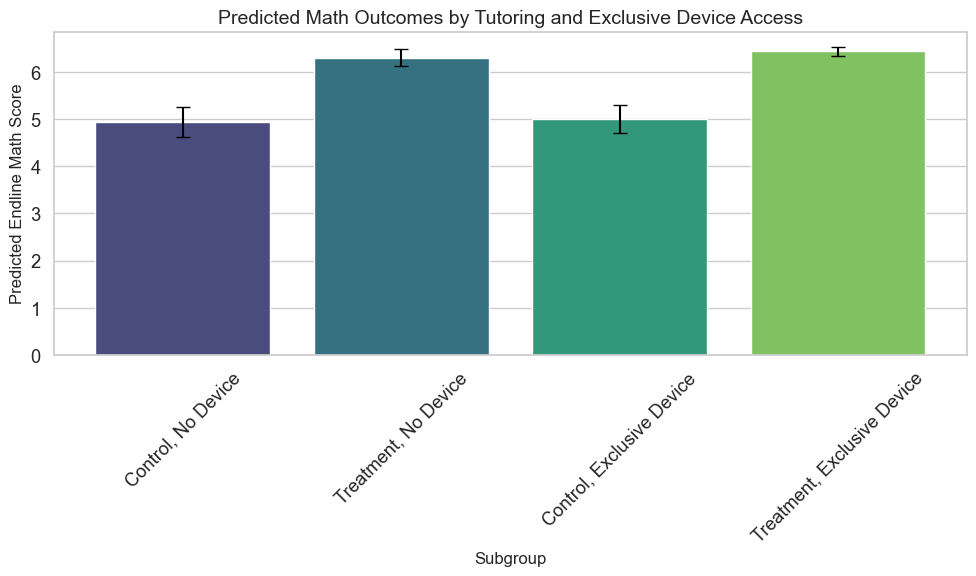

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe with all subgroup combinations
# Use average values for continuous controls
subgroups = pd.DataFrame({
    'treat': [0, 1, 0, 1],
    'exclusive_device': [0, 0, 1, 1],
    'grade_mat_admin_baseline': df_cluster['grade_mat_admin_baseline'].mean(),
    'SES_5': df_cluster['SES_5'].mean(),
    'gender_ft_fs': df_cluster['gender_ft_fs'].mean()
})

# Obtain predicted endline math scores and 95% CI using the fitted cluster-robust model
predictions = model_cluster.get_prediction(subgroups)
pred_summary = predictions.summary_frame(alpha=0.05)
subgroups['predicted'] = pred_summary['mean']
subgroups['ci_lower'] = pred_summary['mean_ci_lower']
subgroups['ci_upper'] = pred_summary['mean_ci_upper']

# Create readable labels for each subgroup
subgroups['group'] = ['Control, No Device', 'Treatment, No Device', 'Control, Exclusive Device', 'Treatment, Exclusive Device']

# Plotting the predictions with error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='group', y='predicted', data=subgroups, palette='viridis', capsize=0.1)

# Retrieve the center positions of the bars from seaborn's patches for precise error bar alignment
bar_centers = [patch.get_x() + patch.get_width()/2 for patch in ax.patches]

# Add error bars using the computed bar centers
for center, (_, row) in zip(bar_centers, subgroups.iterrows()):
    err_lower = row['predicted'] - row['ci_lower']
    err_upper = row['ci_upper'] - row['predicted']
    plt.errorbar(x=center, y=row['predicted'], yerr=[[err_lower], [err_upper]], fmt='none', c='black', capsize=5)

plt.xlabel('Subgroup', fontsize=12)
plt.ylabel('Predicted Endline Math Score', fontsize=12)
plt.title('Predicted Math Outcomes by Tutoring and Exclusive Device Access', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Agent Interpretation

The results from your analysis are visually compelling and suggest some patterns related to the hypothesis. Here’s some feedback and guidance for future steps:

### Feedback on Current Analysis:

1. **Effect Sizes and Confidence Intervals:**
   - The effect sizes show a noticeable increase in predicted math scores when moving from control to treatment, and a further increase with exclusive device access. 
   - Confidence intervals (CIs) appear to be narrow, suggesting precision in your estimates, but it's critical to ensure the cluster-robust standard errors are correctly specified given potential groupings in your data.

2. **Identification Credibility:**
   - Since the analysis is based on predictions from a model using observed data (assuming an RCT setup), the identification credibility should generally be sound. However, accounting for any potential baseline differences or attrition through robustness checks is advisable.
   - Ensure that pre-trend checks (if applicable) and balance tests validate the assumptions for causal inference.

3. **Model Specification:**
   - You've controlled for baseline math scores and SES, which is appropriate. Confirm these controls are sufficient and consider additional controls if any omitted variable bias is plausible.
   - The interactive effect of tutoring and exclusive device access should be carefully interpreted. Check that multicollinearity isn’t distorting these interaction effects by examining variance inflation factors (VIF).

### Suggestions for Future Analysis:

1. **Heterogeneity Analysis:**
   - Explore potential heterogeneity in treatment effects. For instance, look into whether socioeconomic status (SES) modifies the effect of device exclusivity. This helps in understanding the differential impacts within your subgroups.

2. **Robustness Checks:**
   - Consider robustness checks on model assumptions and potential attrition biases. For instance, using bounding techniques for attrition could ensure the results are robust to differential dropout rates.

3. **Longitudinal Analysis:**
   - If the dataset allows, a longitudinal setup could track changes over time and further bolster your causal claims.

4. **Broader Educational Outcomes:**
   - To keep results economically meaningful, you could extend analysis beyond math scores. Explore secondary outcomes like soft skills or aspirations as indicated in the research paper.

5. **Additional Visualizations:**
   - Consider adding more visualizations indicating distributions of score changes or scatter plots with fitted lines to convey model fit and variability across different subgroups.

By attending to these points, you can enhance the credibility and depth of your findings related to the hypothesis.